In [147]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
plt.rcParams['font.size'] = 15

import warnings 
warnings.filterwarnings(action='ignore')

https://growthj.link/python-seaborn-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%8B%9C%EA%B0%81%ED%99%94-%EC%B4%9D%EC%A0%95%EB%A6%AC/
그래프 그리는 함수 참고

In [148]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
#불러올 파일의 경로를 filename 변수에 저장
path = '/content/drive/MyDrive/Colab Notebooks/구내식당 식수인원 예측/data/'
train_raw = pd.read_csv(path+'train.csv', encoding = 'utf-8')    
test_raw = pd.read_csv(path+'test.csv', encoding = 'utf-8')
submission = pd.read_csv(path+'sample_submission.csv', encoding = 'utf-8')
#pandas read_csv로 불러오기
train_raw.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [150]:
print(' train shape: ', train_raw.shape, '\n', 'test shape: ', test_raw.shape)
#중식계 석식계를 예측해보자 

 train shape:  (1205, 12) 
 test shape:  (50, 10)


1. 데이터 전처리


In [151]:
train = train_raw.copy()
#deep copy
train.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn', 'target_ln', 'target_dn']
train.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [152]:
test = test_raw.copy()
test.columns = ['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'brk', 'ln', 'dn']
test.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,목,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [153]:
def to_datetime(df, date):
    df['date'] = pd.to_datetime(df[date])
    df['dow'] = pd.to_datetime(df[date]).dt.weekday + 1
    df['dow'] =  df['dow'].astype('category')
    #월요일 0 일요일 6 -> 월 1 일 7로 변경
    #요일 범주형 처리
 
to_datetime(train, 'date'); 
to_datetime(test, 'date');

In [154]:
train.head(2)


,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [155]:
test.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지


In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1205 non-null   datetime64[ns]
 1   dow        1205 non-null   category      
 2   employees  1205 non-null   int64         
 3   dayoff     1205 non-null   int64         
 4   bustrip    1205 non-null   int64         
 5   ovtime     1205 non-null   int64         
 6   remote     1205 non-null   float64       
 7   brk        1205 non-null   object        
 8   ln         1205 non-null   object        
 9   dn         1205 non-null   object        
 10  target_ln  1205 non-null   float64       
 11  target_dn  1205 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 105.1+ KB


In [157]:
# object type(string)은 분석 안함 
train.describe()

,employees,dayoff,bustrip,ovtime,remote,target_ln,target_dn
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


1.2 메뉴 데이터 분석 & 전처리

In [158]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch = []
for day in range(len(train)):
    tmp = train.iloc[day, 8].split(' ') # 공백으로 문자열 구분 
    tmp = ' '.join(tmp).split()    # 빈 원소 삭제

    search = '('   # 원산지 정보는 삭제
    for menu in tmp:
        if search in menu:
            tmp.remove(menu)
    
    lunch.append(tmp) 

In [159]:
len(lunch[0])

7

In [160]:
lunch[0:5]

[['쌀밥/잡곡밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '떡국', '돈육씨앗강정', '우엉잡채', '청경채무침', '요구르트', '포기김치']]

In [161]:
lunch[1065:1070]

[['쌀밥/잡곡밥', '매운소고기국', '굴비구이', '토마토프리타타', '도라지오이무침', '배추겉절이'],
 ['돈육버섯고추장덮밥', '팽이무국', '양파링카레튀김', '모듬어묵볶음', '참나물생채', '요구르트', '포기김치'],
 ['쌀밥/잡곡밥', '냉모밀국수', '매운돈갈비찜', '메밀전병*간장', '고구마순볶음', '포기김치', '양상추샐러드*딸기요거트'],
 ['쌀밥/잡곡밥', '대파육개장', '홍어미나리초무침', '어묵잡채', '콩자반', '배추겉절이', '양상추샐러드*오리엔탈'],
 ['카레라이스', '동태알탕', '부추고추전*간장', '쫄면야채무침', '과일요거트샐러드', '포기김치', '요구르트']]

밥/국/반찬/사이드 순서가 깨지는 것을 확인 -> 단순 index slicing으로는 분석 불가능
다른 방향의 메뉴분석 방법이 필요할 것 같음

In [162]:
# lunch train data에 밥, 국, 반찬 1-3, 김치, 사이드로 구분해서 생성
bob = []; gook = []; banchan1 = []; banchan2 = []; banchan3 = []; kimchi = []; side = []
for i, day_menu in enumerate(lunch):
    bob_tmp = day_menu[0]; bob.append(bob_tmp)
    gook_tmp = day_menu[1]; gook.append(gook_tmp)
    banchan1_tmp = day_menu[2]; banchan1.append(banchan1_tmp)
    banchan2_tmp = day_menu[3]; banchan2.append(banchan2_tmp)
    banchan3_tmp = day_menu[4]; banchan3.append(banchan3_tmp)

    if i < 1067:
        kimchi_tmp = day_menu[-1]; kimchi.append(kimchi_tmp)
        side_tmp = day_menu[-2]; side.append(side_tmp)
    else: 
        kimchi_tmp = day_menu[-2]; kimchi.append(kimchi_tmp)
        side_tmp  = day_menu[-1]; side.append(side_tmp)
        
train_ln = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'ln', 'target_ln']]
train_ln['bob'] = bob
train_ln['gook'] = gook
train_ln['banchan1'] = banchan1; train_ln['banchan2'] = banchan2; train_ln['banchan3'] = banchan3
train_ln['kimchi'] = kimchi 
train_ln['side'] = side
train_ln.iloc[1066:1070, 7:]

,ln,target_ln,bob,gook,banchan1,banchan2,banchan3,kimchi,side
1066,"돈육버섯고추장덮밥 (쌀,돈육:국내산) 팽이무국 양파링카레튀김 모듬어묵볶음 참나...",516.0,돈육버섯고추장덮밥,팽이무국,양파링카레튀김,모듬어묵볶음,참나물생채,포기김치,요구르트
1067,쌀밥/잡곡밥 냉모밀국수 매운돈갈비찜 메밀전병*간장 고구마순볶음 포기김치 양상추샐러드...,866.0,쌀밥/잡곡밥,냉모밀국수,매운돈갈비찜,메밀전병*간장,고구마순볶음,포기김치,양상추샐러드*딸기요거트
1068,쌀밥/잡곡밥 대파육개장 홍어미나리초무침 어묵잡채 콩자반 배추겉절이 양상추샐러드*오리엔탈,675.0,쌀밥/잡곡밥,대파육개장,홍어미나리초무침,어묵잡채,콩자반,배추겉절이,양상추샐러드*오리엔탈
1069,카레라이스 동태알탕 부추고추전*간장 쫄면야채무침 과일요거트샐러드 포기김치 요구르트,607.0,카레라이스,동태알탕,부추고추전*간장,쫄면야채무침,과일요거트샐러드,포기김치,요구르트


In [163]:
# 밥 데이터 개수 확인
bob_df = pd.DataFrame(train_ln['bob'].value_counts().reset_index())
bob_df.head(10)

,index,bob
0,쌀밥/잡곡밥,879
1,쌀밥/흑미밥/찰현미밥,74
2,콩나물밥,23
3,카레덮밥,18
4,나물비빔밥,15
5,곤드레밥*강된장,12
6,단호박영양밥,10
7,쌀밥/수수밥/찰현미밥,10
8,곤드레밥*양념장,8
9,김치제육덮밥,8


In [164]:
# 반찬 데이터 개수 확인
banchan_list = []
for i in range(3):
    tmp = train_ln[f'banchan{i+1}']
    for j in range(len(train_ln)):
        tmp2 = tmp[j]
        banchan_list.append(tmp2)

banchan_df = pd.DataFrame(pd.DataFrame(banchan_list).value_counts())
banchan_df.columns = ['banchan']
banchan_df.reset_index(inplace = True)
banchan_df.columns = ['index', 'banchan']
banchan_df.head(10)

,index,banchan
0,오이무침,35
1,오징어볶음,32
2,닭갈비,30
3,버섯불고기,29
4,콩나물무침,28
5,계란말이,28
6,훈제오리구이,27
7,돈육굴소스볶음,25
8,계란찜,24
9,숙주나물,24


In [165]:
#데이터 합치기 (밥, 국, 반찬1 반영)
train = pd.concat([train, train_ln[['bob','banchan1', 'gook']]], axis = 1)
train.head(3)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn,bob,banchan1,gook
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,쌀밥/잡곡밥,쇠불고기,오징어찌개
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,쌀밥/잡곡밥,가자미튀김,김치찌개
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,카레덮밥,치킨핑거,팽이장국


2. 시각화 및 EDA

In [166]:
train.head(2)

,date,dow,employees,dayoff,bustrip,ovtime,remote,brk,ln,dn,target_ln,target_dn,bob,banchan1,gook
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,쌀밥/잡곡밥,쇠불고기,오징어찌개
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,쌀밥/잡곡밥,가자미튀김,김치찌개


2.1 점심 및 저녁 이용자 수

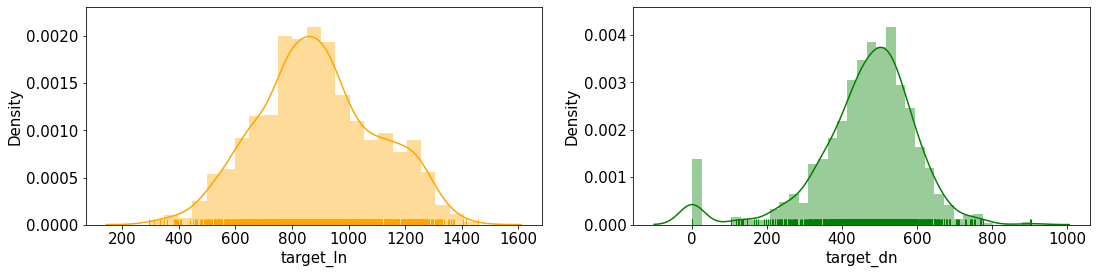

In [167]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 4))
#kde -> 분포 선(kernel density plot)을 그려줌 rug-> rugplot
sns.distplot(train["target_ln"], ax = ax[0], color = 'orange', kde = True, rug = True)
sns.distplot(train["target_dn"], ax = ax[1], color = 'green', kde = True, rug = True)
plt.show()

- 점심 이용자수는 눈에 띄는 특징은 없음, 정규분포인가?
  - 이용자수가 200명 남짓에서 1600명까지 넓게 퍼져있음
- 저녁 이용자수는 특이하게 0명인 날이 존재하는 것 같습니다(이상치 이유 확인 필요). 
  - 이용자수는 몇 백명 (100~800여 명) 정도의 범위이고,    전반적으로 점심보다 저녁 이용자수가 더 적습니다. 

2.2 일자별 분석

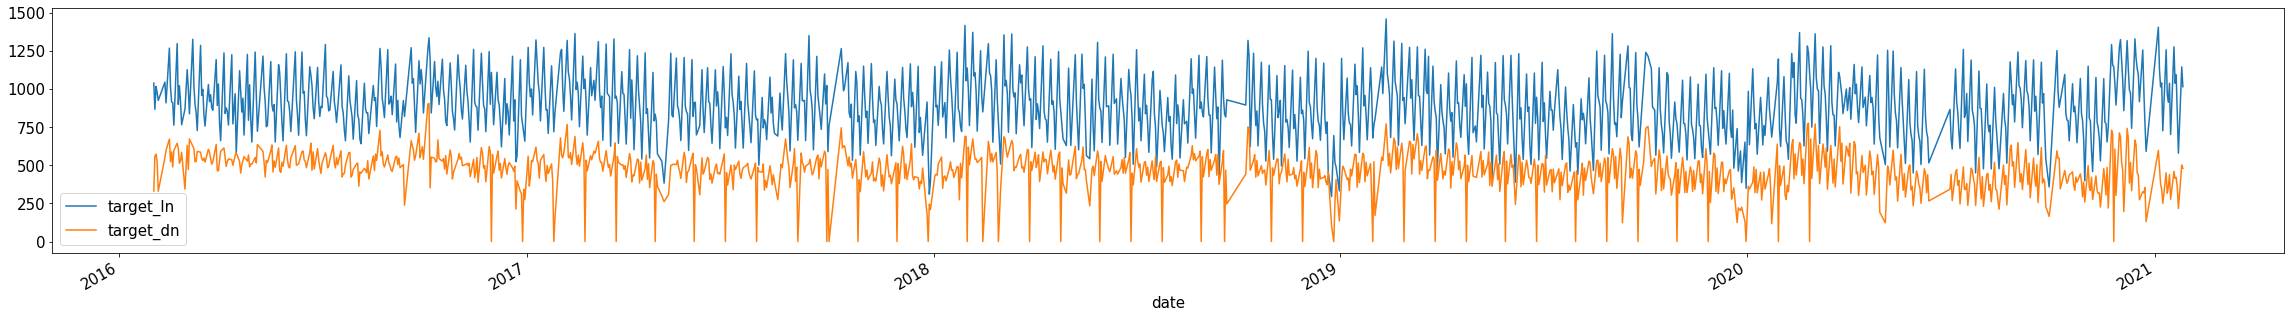

In [168]:
train.plot(x = 'date', y = ['target_ln', 'target_dn'], figsize = (40, 5))
plt.show()

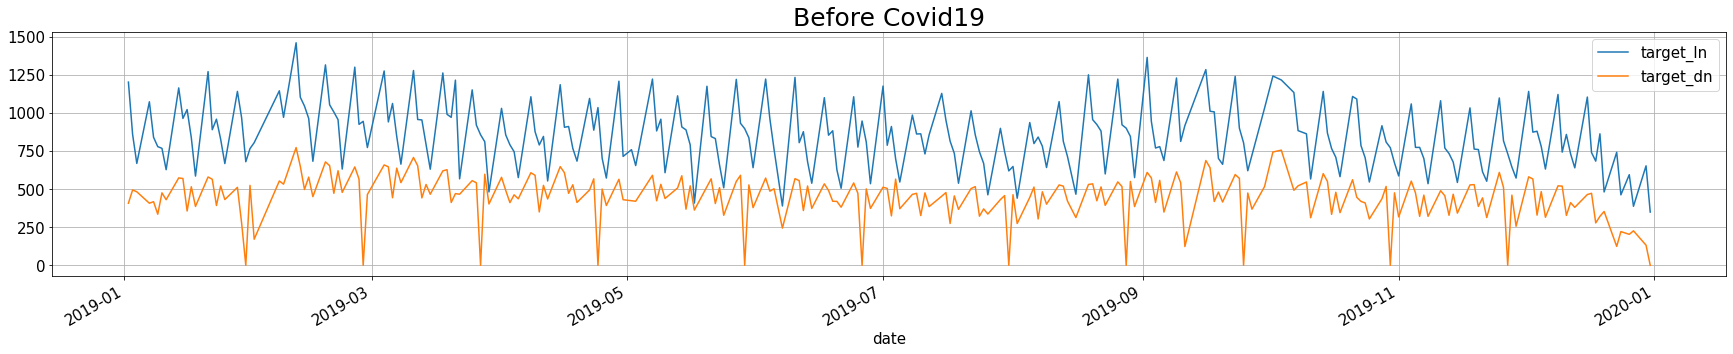

In [169]:
before_covid = train[train['date'].dt.year == 2019][['date', 'target_ln', 'target_dn']]
before_covid.plot(x = 'date', y = ['target_ln', 'target_dn'], figsize = (30, 5), grid = True)
plt.title('Before Covid19', fontsize = 25)
plt.show()

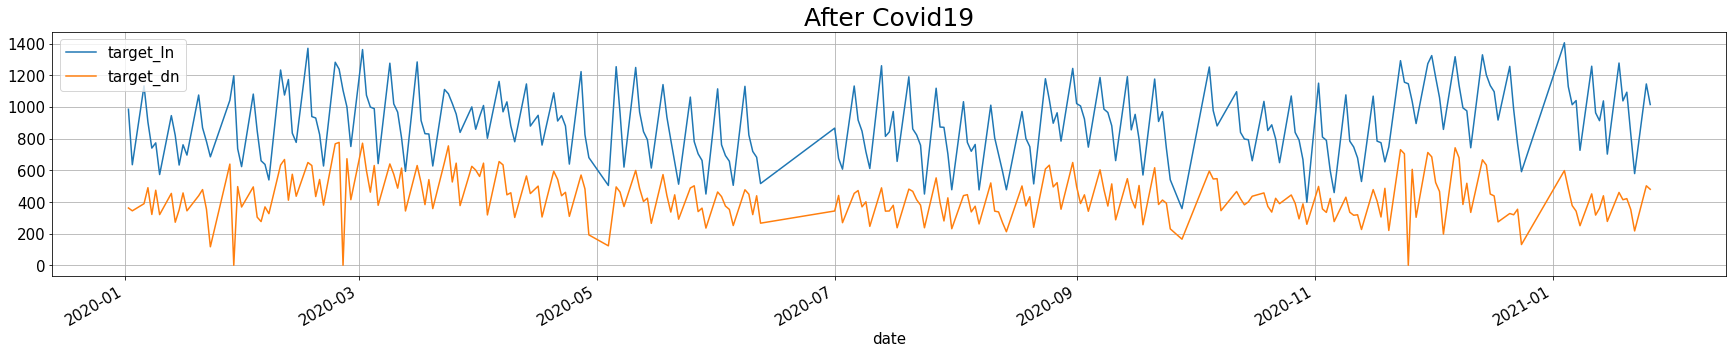

In [170]:
after_covid = train[train['date'].dt.year >= 2020][['date', 'target_ln', 'target_dn']]
after_covid.plot(x = 'date', y = ['target_ln', 'target_dn'], figsize = (30, 5), grid = True)
plt.title('After Covid19', fontsize = 25)
plt.show()

In [171]:
print('점심:', '2019년에는', round(before_covid.target_ln.mean(), 2), ', 2020년에는', round(after_covid.target_ln.mean(), 2))
print('저녁:', '2019년에는', round(before_covid.target_dn.mean(), 2), ', 2020년에는', round(after_covid.target_dn.mean(), 2))

점심: 2019년에는 850.51 , 2020년에는 890.97
저녁: 2019년에는 445.39 , 2020년에는 428.34


2019년과 2020년만을 따로 보니, 딱히 코로나19로 인해 점심/저녁 이용자수가 크게 달라진 것 같진 않습니다.

- 오히려 점심의 경우, 2020년 이용자수 평균(890명)이 2019년(850명)보다 높았습니다.
- 혹시 2020년동안 총 직원수가 늘어나서 그런건지 확인해보겠습니다.

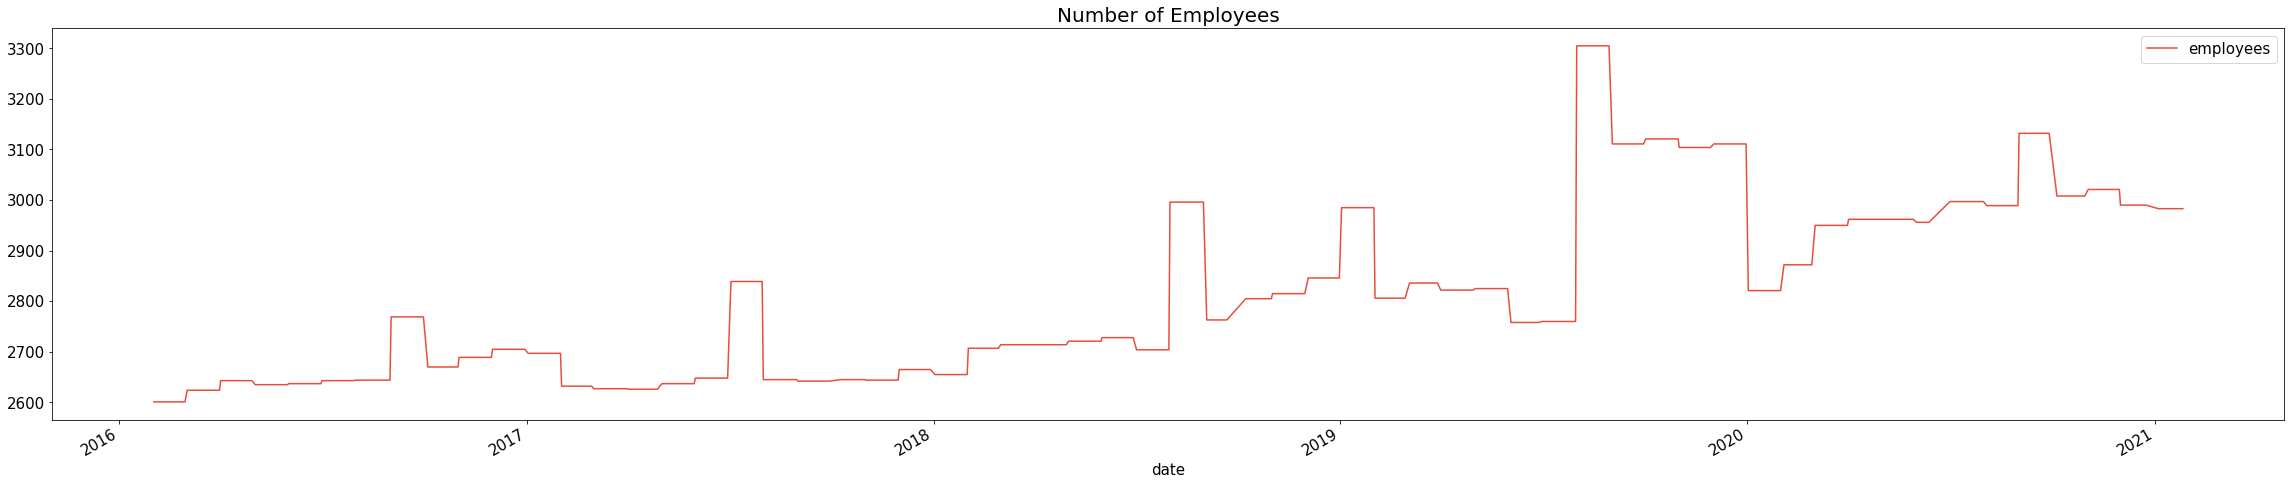

In [172]:
train.plot(x = 'date', y = 'employees', figsize = (40, 8), c = "#e74c3c")
plt.title("Number of Employees", fontsize = 20)
plt.show()

본사의 총 정원수가 조금씩 증가하는 양상을 보이기는 하지만, 2019년과 2020년만을 비교해보면 딱히 2020년 정원수가 더 많다고는 할 수 없을 것 같습니다. 2019년 하반기에 정원수가 급증한 때가 있기 때문입니다

<Strong>저녁 식수인원 0명 데이터 확인<Strong>

In [173]:
train[train.target_dn == 0][['date',  'dayoff', 'bustrip', 'ovtime', 'remote', 'dow', 'dn', 'target_dn']]

,date,dayoff,bustrip,ovtime,remote,dow,dn,target_dn
204,2016-11-30,68,207,0,0.0,3,*,0.0
224,2016-12-28,166,225,0,0.0,3,*,0.0
244,2017-01-25,79,203,0,0.0,3,*,0.0
262,2017-02-22,75,252,0,0.0,3,*,0.0
281,2017-03-22,53,235,0,0.0,3,*,0.0
306,2017-04-26,45,304,0,0.0,3,*,0.0
327,2017-05-31,43,265,0,0.0,3,자기계발의날,0.0
346,2017-06-28,58,259,0,0.0,3,*자기계발의날*,0.0
366,2017-07-26,254,246,0,0.0,3,가정의날,0.0
392,2017-09-01,177,303,45,0.0,5,*,0.0


저녁 이용자가 0명이었던 이유

월별 마지막 (또는 그 전 주) 수요일(dow가 3인 날)은 '자기개발의 날'이라서 모두 정시 퇴근을 하는 (해야하는) 날인가 봅니다. 아예 저녁 메뉴가 빈 칸인 것을 보면 말이죠.
저녁 메뉴가 제공됨에도 불구하고 저녁 이용자가 0명인 날이 딱 2일 있습니다. 2017-09-27와 2018-02-14 입니다. 이 날들은 긴 공휴일 전후의 날짜일까 싶어 확인해보았습니다.
예전 달력을 확인해보니, 2017-09-27은 공휴일 직전은 아니었지만, 2017년의 유명한 황금연휴 전 주였습니다. 개천절, 추석, 대체휴일, 한글날까지 황금연휴였지요.
2018-02-14은 예상대로 2018-02-15 ~ 17일까지의 설날 연휴 전날이었습니다.

2.3 변수 간 상관관계

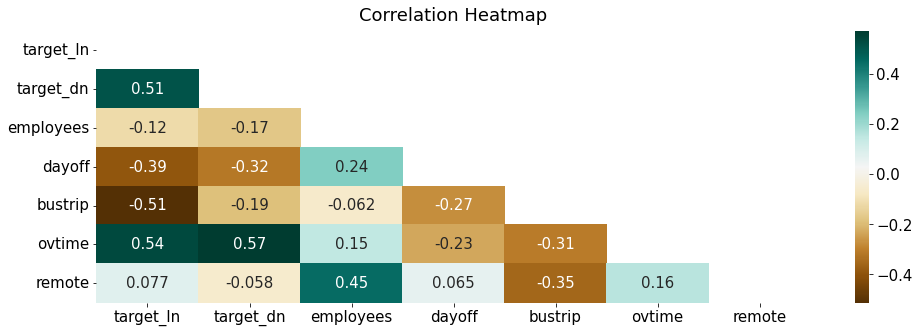

In [174]:
df = train[['target_ln', 'target_dn', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote']]
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool)) #upper tri 1로 바꾸기 -> true로 바꾸기
plt.rcParams['font.size'] = 15

fig, ax = plt.subplots(figsize=(16, 5))
sns.heatmap(df.corr(), #pearson corr
            annot=True, #셀의 값 표기 여부
            cmap="BrBG", #색깔 
            mask = mask) #if true -> 값이 표시 안됨 
ax.set_title('Correlation Heatmap', pad = 10)
plt.show()

일반적으로, 상관계수의 크기가 0.4 이상이면 상관성이 있다고 볼 수 있음
- Case1 점심
  - 가장 상관관계가 높은 독립변수는 ovtime (0.54) (시간외근무자수)이고, 그 다음으로는 bustrip (-0.51)  (출장자수) 입니다.
  - 특이한 것은, 시간외근무자라는 것은 야근을 한다는 것인데, 저녁뿐만이 아니라 점심 이용자수와도 상관관계를 보인다는 점입니다.
  - dayoff (-0.39)(휴가자수) 또한 출장자수와 비슷하게, 음의 관계를 갖고 있습니다. dayoff의 상관계수의 크기는 bustrip의 계수보다는 작지만요.
- Case2: 저녁
 - 점심 때와 크게 다르지는 않습니다.
 -  차이가 있다면 애초에 회사 내에 없었던 직원들의 수 (bustrip, dayoff)와의 상관관계가 점심 때보다는 약해졌다는 것입니다.
  - 이보다 더 중요하다고 생각되는 점은 ovtime의 상관계수가 0.57로 조금 커진 것입니다. -> 야근하는 직원수가 많으면 당연히 저녁 이용자수가 많아질 것이니까요.

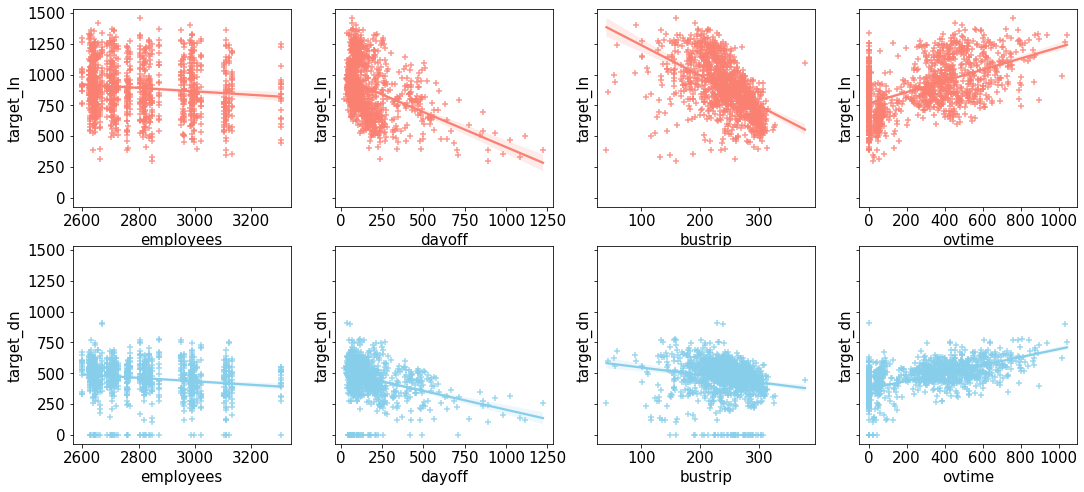

In [175]:
fig, ax = plt.subplots(figsize = (18, 8), ncols = 4, nrows = 2, sharey=True)
plt.rcParams['font.size'] = 12
sns.color_palette("Paired")
train_features = ['employees', 'dayoff', 'bustrip', 'ovtime', 'employees', 'dayoff', 'bustrip', 'ovtime']
for i, feature in enumerate(train_features):
    row = int(i/4)
    col = i%4 
    if i < 4:
        sns.regplot(x=feature, y = 'target_ln', data = train, ax = ax[row][col], color = 'salmon', marker = '+')
    else: 
        sns.regplot(x=feature, y = 'target_dn', data = train, ax = ax[row][col], color = 'skyblue', marker = '+')

2.4 월별 요일별 패턴

(1) 점심 및 저녁 이용자 수 가설
  - 월별로 차이: 가정의 달이나 외부 출장이 많은 달, 업무가 많은 달 등 
  - 요일: 금요일 저녁은 수가 줄 것

In [176]:
tmp = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_ln', 'target_dn']]
tmp['month'] = tmp['date'].dt.strftime("%m")

tmp_ln = tmp.groupby(['dow', 'month'])['target_ln'].mean().reset_index().pivot('dow', 'month', 'target_ln')
tmp_dn = tmp.groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')

In [177]:
tmp_ln.head()

month,01,02,03,04,05,06,07,08,09,10,11,12
dow,,,,,,,,,,,,
1,1210.210526,1245.526316,1239.428571,1156.045455,1103.263158,1131.823529,1106.391304,1109.800000,1148.750000,1127.263158,1134.714286,1047.350000
2,994.500000,1006.055556,975.476190,863.476190,935.315789,925.470588,887.545455,893.523810,933.263158,964.157895,881.523810,859.300000
3,918.095238,1004.666667,974.428571,895.315789,924.285714,890.764706,839.090909,869.045455,930.944444,920.368421,855.954545,857.947368
4,856.095238,936.736842,910.500000,839.100000,781.619048,807.157895,765.952381,798.318182,822.777778,859.611111,764.545455,760.190476
5,679.333333,756.789474,683.136364,650.190476,608.000000,612.250000,629.227273,628.181818,684.105263,690.470588,614.545455,626.809524


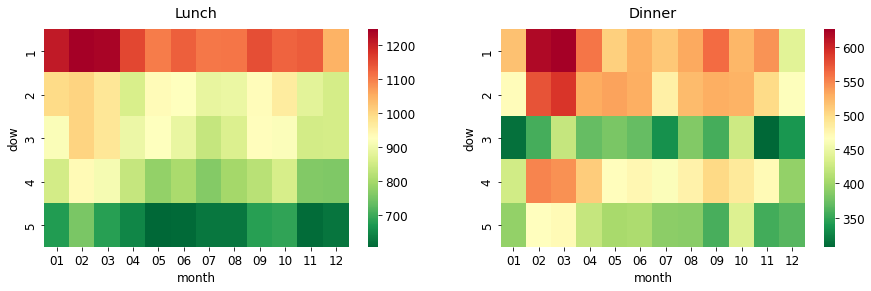

In [178]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

sns.heatmap(tmp_ln, cmap='RdYlGn_r', ax=ax[0])
ax[0].set_title('Lunch', pad = 12)
sns.heatmap(tmp_dn, cmap='RdYlGn_r', ax=ax[1])
ax[1].set_title('Dinner', pad = 12)

plt.show()

점심
- 월요일에 압도적으로 이용자수가 많습니다. 유일하게 빨갛네요. 늘 1000명보다 많다는 뜻이겠죠.
  - 월요일이라도 2월과 3월에는 이용자수가 더 많음
  - 1년 내내 월요일이 다른 날 보다 많음
- 2월 3월에는 화요일과 수요일에 대략 1000명정도의 사람이 있음
- 목요일 금요일에는 이용자 수가 적음

저녁
- 점심과 마찬가지로 월요일이 가장 많음
- 화요일에도 이용자수가 비슷하게 많음
- 수요일에는 저녁 이용자 수가 매우 적음 -> 자기 개발의 날이 이유로 추정

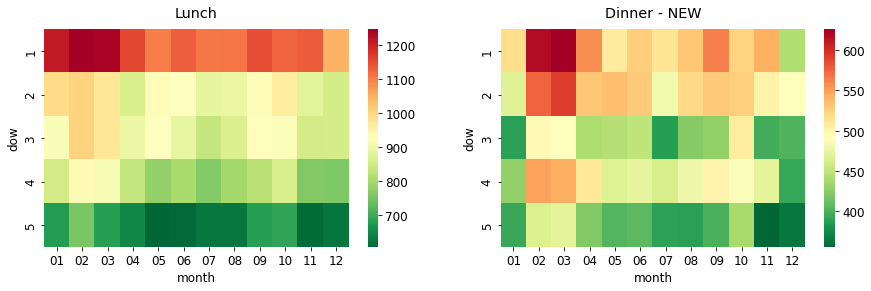

In [179]:
# 자기개발의 날 삭제 
idx = train[train.target_dn == 0].index
tmp = train.drop(idx)
tmp['month'] = tmp['date'].dt.strftime("%m")
tmp_dn2 = tmp.groupby(['dow', 'month'])['target_dn'].mean().reset_index().pivot('dow', 'month', 'target_dn')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

sns.heatmap(tmp_ln, cmap='RdYlGn_r', ax=ax[0])
ax[0].set_title('Lunch', pad = 12)
sns.heatmap(tmp_dn2, cmap='RdYlGn_r', ax=ax[1])
ax[1].set_title('Dinner - NEW', pad = 12)

plt.show()

- 자기 개발의 날을 제외했는데도 수요일에는 여전히 이용자 수가 적음
- 금요일에도 적음
- 2,3월 월 화에는 많은 편
=> 요일별 패턴이 중요한듯


(2)회사 내의 직원수 분석
  -  회사 내에 있는 직원수는 employees - (dayoff + bustrip + remote) 으로 구할 수 있을 것입니다. 다시 말해, 본사정원수 - (본사휴가자수 + 본사출장자수 + 재택근무자수)
  - 이를 구하기 전에, 휴가자수(dayoff), 출장자수(bustrip), 시간외근무자수(ovtime), 재택근무자수(remote)를 요일별 & 월별로 시각화
    - 다만, 재택근무수를 확인해보니 (아래), 코로나 이전인 2019년 까지는 0명이었습니다. 그러므로, 재택근무자수는 2020년의 데이터만 시각화하겠습니다.

In [180]:
before = train['date'].dt.year < 2020
after = train['date'].dt.year >= 2020

train[before]['remote'].value_counts()  # 코로나19 전 재택근무자수 

0.0    956
Name: remote, dtype: int64

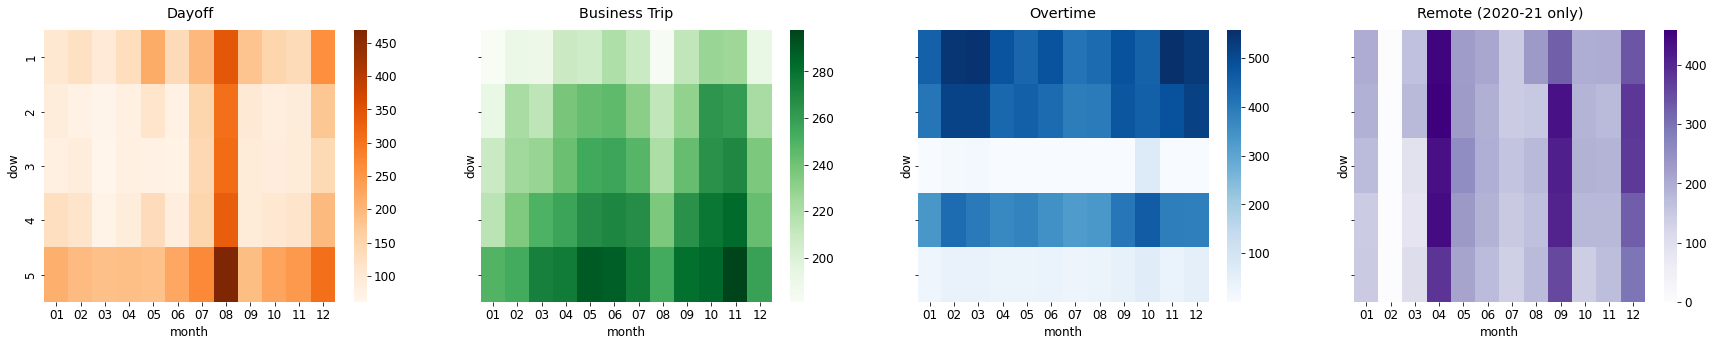

In [181]:
before = train['date'].dt.year < 2020
after = train['date'].dt.year >= 2020

def heatmap_viz(df): 
    df['month'] = df['date'].dt.strftime("%m")
    before = df['date'].dt.year < 2020
    after = df['date'].dt.year >= 2020

    tmp_dayoff = df.groupby(['dow', 'month'])['dayoff'].mean().reset_index().pivot('dow', 'month', 'dayoff')
    tmp_bustrip = df.groupby(['dow', 'month'])['bustrip'].mean().reset_index().pivot('dow', 'month', 'bustrip')
    tmp_ovtime = df.groupby(['dow', 'month'])['ovtime'].mean().reset_index().pivot('dow', 'month', 'ovtime')
    tmp_remote_after = df[after].groupby(['dow', 'month'])['remote'].mean().reset_index().pivot('dow', 'month', 'remote')

    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (30, 5), sharey = True)

    sns.heatmap(tmp_dayoff, cmap='Oranges', ax=ax[0])   #1 
    ax[0].set_title('Dayoff', pad = 12)
    sns.heatmap(tmp_bustrip, cmap='Greens', ax=ax[1])   #2 
    ax[1].set_title('Business Trip', pad = 12)
    sns.heatmap(tmp_ovtime, cmap='Blues', ax=ax[2])   #3
    ax[2].set_title('Overtime', pad = 12)
    sns.heatmap(tmp_remote_after, cmap='Purples', ax=ax[3])   # 4
    ax[3].set_title('Remote (2020-21 only)', pad = 12)
   
    plt.show()

df = train[['date', 'dow', 'dayoff', 'bustrip', 'ovtime', 'remote']]
heatmap_viz(df)

- 휴가자수: 금, 7,8, 12월 특히 8월이 제일 많음
- 출장자 수: 금, 5,6,7,10,11
- 시간외근무자 수: 월,화, 목, 월은 2,3월
- 재택근무자수: 4,9,12월

회사 내에 있는 직원수 = employees - (dayoff + bustrip + remote)

In [182]:
df = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_ln', 'target_dn']]
df['in_office'] = df['employees'] - (df['dayoff'] + df['bustrip'] + df['remote'])
df['month'] = df['date'].dt.strftime("%m")
df.head(3)

,date,dow,employees,dayoff,bustrip,ovtime,remote,target_ln,target_dn,in_office,month
0,2016-02-01,1,2601,50,150,238,0.0,1039.0,331.0,2401.0,02
1,2016-02-02,2,2601,50,173,319,0.0,867.0,560.0,2378.0,02
2,2016-02-03,3,2601,56,180,111,0.0,1017.0,573.0,2365.0,02


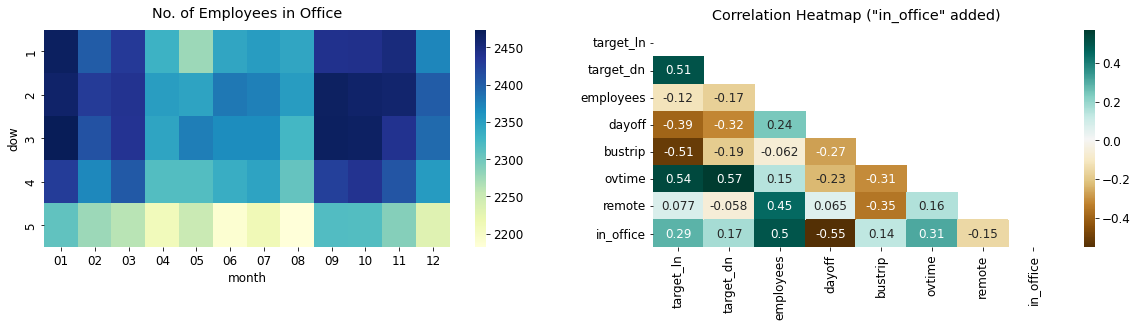

In [183]:
tmp = df.groupby(['dow', 'month'])['in_office'].mean().reset_index().pivot('dow', 'month', 'in_office')

# Heatmap
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))

sns.heatmap(tmp, cmap='YlGnBu', ax = ax[0])    # 1 
ax[0].set_title('No. of Employees in Office', pad = 12)

df_corr = df[['target_ln', 'target_dn', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'in_office']]   # 2
mask = np.triu(np.ones_like(df_corr.corr(), dtype=np.bool))
sns.heatmap(df_corr.corr(), 
            annot=True, 
            cmap="BrBG", 
            mask = mask, 
            ax =ax[1])
ax[1].set_title('Correlation Heatmap ("in_office" added)', pad = 10)
plt.show()

회사 내 직원 수가 금요일에는 매우 적음
월별로 봐도 1-3월, 9-11월에는 사람 많음
- 상관 관계 분석
  - 0.29, 0.17로 큰 상관성은 없음 오히려 개별 데이터보다 상관성이 떨어짐을 확인

각 메뉴의 선호도 조사가 힘들기 때문에 요일 데이터, 월별 데이터를 기본으로 이용
월 데이터의 경우: 특정달에 몰리는 경우가 발생하는 듯, 이 또한 숫자 data가 아닌 범주형 data로 처리 필요

- 점심: ovtime (0.54) (시간외근무자수), bustrip (-0.51) (출장자수) factor 추가
- 저녁: ovtime factor, target_ln data factor로 이용(저녁 식수 때는 점심 식수 인원이 이미 계측된다고 가정)

다중회귀 분석 실행

In [184]:
final = train[['date', 'dow', 'employees', 'dayoff', 'bustrip', 'ovtime', 'remote', 'target_ln', 'target_dn', 'bob', 'gook', 'banchan1']]
final['month'] = final['date'].dt.strftime("%m").astype('category')
final['dow'] = final['dow'].astype('category')

1. targe_ln 예측

1. data 분리하기

In [185]:
from sklearn.model_selection import train_test_split

In [186]:
# 메뉴중에서는 밥이 무엇인지만 포함 (국, 반찬은 종류가 다양해서 예측에 유의미한 정보를 가지고 있지 않음, 오히려 예측에 불리하게 작용)
x = final[['month', 'dow', 'employees', 'bustrip', 'ovtime', 'bob']]
y = final[['target_ln']]

In [187]:
#범주형 data one hot encoding
x = pd.get_dummies(data=x, drop_first=True)
x.head()

,employees,bustrip,ovtime,month_02,month_03,month_04,month_05,month_06,month_07,month_08,...,bob_짜장덮밥,bob_짜장밥,bob_참치회덮밥,bob_카레덮밥,bob_카레라이스,bob_콩나물밥,bob_콩나물밥*달래장,bob_콩나물밥*양념장,bob_파인애플볶음밥,bob_호박된장국
0,2601,150,238,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2601,173,319,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2601,180,111,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2601,220,355,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2601,181,34,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

2. 회귀 분석

In [189]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(x_train, y_train) 

LinearRegression()

In [190]:
y_predict = mlr.predict(x_test)

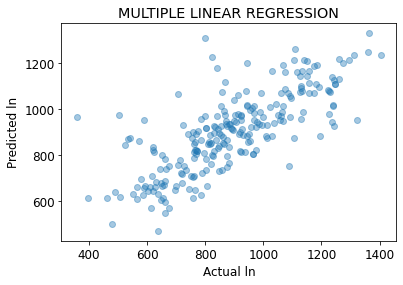

In [191]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual ln")
plt.ylabel("Predicted ln")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [192]:
print(mlr.intercept_, mlr.coef_, mlr.score(x_train, y_train))


[2081.55776433] [[-2.26405334e-01 -5.84967506e-01  4.27906591e-01  1.56007869e+01
  -2.94100627e+00 -6.64852118e+01 -6.69302017e+01 -7.46811714e+01
  -7.66195549e+01 -5.74346253e+01 -4.55922259e+00 -2.33960969e+01
  -6.57162751e+01 -1.23267671e+02 -1.98109914e+02 -3.63777834e+00
  -2.47152880e+02 -2.60585743e+02 -1.85581460e+02  4.81463758e-11
  -3.94959554e+02 -1.81616000e+02 -3.90857977e+02 -4.14931262e+02
  -3.59046511e+02 -4.19716230e+02 -2.50640559e+02 -3.18323146e-12
  -2.21396578e+02 -3.16424384e+02 -3.28926314e+02 -3.62514761e+02
  -3.25490112e+02 -3.11975409e+02 -4.02709509e+02 -4.04706818e+02
  -4.13057722e+02 -4.07230080e+02 -3.84647340e+02 -3.59398110e+02
  -3.69157890e+02 -4.01811137e+02 -2.99892140e+02 -3.13348856e+02
  -1.42108547e-14 -5.23657609e+02 -3.67188568e+02  1.42108547e-14
  -3.39231102e+02 -3.52194802e+02 -6.02439135e+01 -5.14580297e+02
  -3.48304629e+02 -3.90148235e+02  7.10542736e-15 -1.96898335e+02
  -4.16634656e+02 -3.21808216e+02 -3.51912582e+02 -4.1136882

In [193]:
#add constant to predictor variables
x = sm.add_constant(x_train);

#fit linear regression model
model = sm.OLS(y_train, x_train).fit();

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              target_ln   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              607.5
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                        0.00
Time:                        04:30:44   Log-Likelihood:                         -5976.2
No. Observations:                 964   AIC:                                  1.212e+04
Df Residuals:                     880   BIC:                                  1.253e+04
Df Model:                          84                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

target_in(점심) 잔차분석

In [194]:
from statsmodels.formula.api import ols
residual = y_test - y_predict

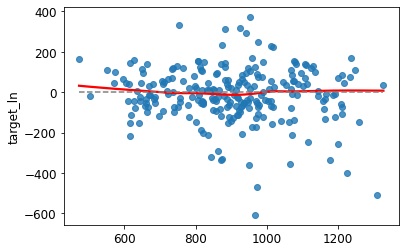

In [195]:
# 모형의 선형성 확인
sns.regplot(y_predict, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([y_predict.min(), y_predict.max()], [0, 0], '--', color='grey')

In [196]:
# 잔차의 정규성 확인 ( 샤피로 검정 ) -> 잔차는 정규분포를 따른다고 가정
import scipy.stats
sr = scipy.stats.zscore(residual)
scipy.stats.shapiro(residual) # p-value 값을 보아 잔차의 정규성이 위반되었다고 판단한다.

ShapiroResult(statistic=0.9521751999855042, pvalue=3.8619046449639427e-07)

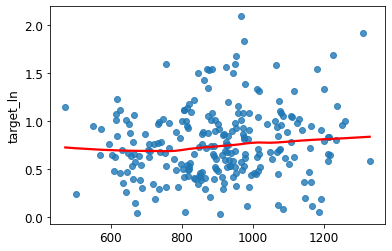

In [197]:
# 잔차의 등분산성 확인 -> 빨간 실선이 수평이면 이상적임
sns.regplot(y_predict, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})

2. target_dn 예측

In [198]:
# 메뉴중에서는 밥이 무엇인지만 포함
x = final[['month', 'dow', 'employees', 'bustrip', 'ovtime', 'target_ln', 'bob']]
y = final[['target_dn']]

In [199]:
#범주형 data one hot encoding
x = pd.get_dummies(data=x, drop_first=True)
x.head()

,employees,bustrip,ovtime,target_ln,month_02,month_03,month_04,month_05,month_06,month_07,...,bob_짜장덮밥,bob_짜장밥,bob_참치회덮밥,bob_카레덮밥,bob_카레라이스,bob_콩나물밥,bob_콩나물밥*달래장,bob_콩나물밥*양념장,bob_파인애플볶음밥,bob_호박된장국
0,2601,150,238,1039.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2601,173,319,867.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2601,180,111,1017.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2601,220,355,978.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2601,181,34,925.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

In [201]:
mlr = LinearRegression()
mlr.fit(x_train, y_train) 

LinearRegression()

In [202]:
y_predict = mlr.predict(x_test)

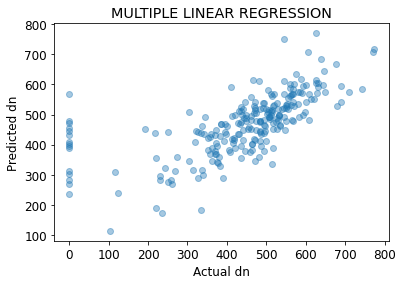

In [203]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual dn")
plt.ylabel("Predicted dn")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [204]:
print(mlr.coef_)
print(mlr.score(x_train, y_train))

[[-1.17741044e-01  3.69013570e-02  3.02422367e-01  2.76268164e-01
   3.67808534e+01  6.46003606e+01  4.48935998e+01  2.31216347e+01
   1.79094420e+01  3.37086703e+01  6.16911297e+01  4.24145180e+01
   5.38941424e+01  3.21744134e+01 -1.92299892e+01  5.25621210e+01
   8.02838838e+01  6.47504841e+01  1.41785309e+02 -1.07524585e+02
   2.08586926e-10 -2.26243984e+02 -2.37611111e+02 -9.98243737e+01
  -1.15409893e+02 -9.57839860e+01 -1.36251895e+02 -1.07351673e+02
  -1.06468291e+02 -9.68669173e+01 -1.59950093e+02 -1.17381660e-10
  -2.71185146e+02 -8.62975790e+01 -1.16320323e+02 -1.20948620e+02
  -1.30561132e+02 -1.10649268e-11  2.35367281e-12 -1.78472176e+02
  -2.55559435e+02 -6.58837222e+01  4.26325641e-14 -1.44690555e+02
  -1.45283694e+02  3.55271368e-14 -9.87309530e+01 -2.47800302e+02
  -1.39581289e+02 -1.24930248e+02 -4.32823267e+01 -2.05984317e+02
   9.23705556e-14 -1.70634820e+02 -8.95131398e+01 -2.89913812e+02
   7.10542736e-15 -1.77559142e+02 -1.53620069e+02 -2.10962085e+02
  -3.26000

In [205]:
#add constant to predictor variables
x = sm.add_constant(x_train);

#fit linear regression model
model = sm.OLS(y_train, x_train).fit();

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              target_dn   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              320.5
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                        0.00
Time:                        04:30:46   Log-Likelihood:                         -5678.5
No. Observations:                 964   AIC:                                  1.152e+04
Df Residuals:                     882   BIC:                                  1.192e+04
Df Model:                          82                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

0일 때 예측이 떨어짐 0을 제외하면? 어떨까(0일 때는 문화가 있는 날 등 예측이 필요없는 일자인 경우가 많음)

In [206]:
# 자기개발의 날 삭제 
idx = final[final.target_dn == 0].index
final_drop0 = final.drop(idx)

In [207]:
# 메뉴중에서는 밥이 무엇인지만 포함
x = final_drop0[['month', 'dow', 'employees', 'bustrip', 'ovtime', 'target_ln', 'bob']]
y = final_drop0[['target_dn']]

In [208]:
#범주형 data one hot encoding
x = pd.get_dummies(data=x, drop_first=True)
x.head()

,employees,bustrip,ovtime,target_ln,month_02,month_03,month_04,month_05,month_06,month_07,...,bob_짜장덮밥,bob_짜장밥,bob_참치회덮밥,bob_카레덮밥,bob_카레라이스,bob_콩나물밥,bob_콩나물밥*달래장,bob_콩나물밥*양념장,bob_파인애플볶음밥,bob_호박된장국
0,2601,150,238,1039.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2601,173,319,867.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2601,180,111,1017.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2601,220,355,978.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2601,181,34,925.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

In [210]:
mlr = LinearRegression()
mlr.fit(x_train, y_train) 

LinearRegression()

In [211]:
y_predict = mlr.predict(x_test)

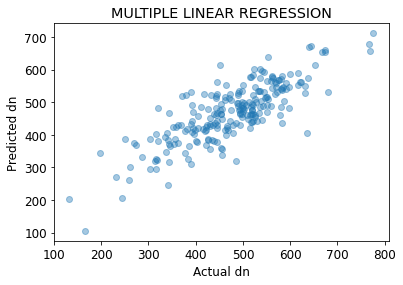

In [212]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual dn")
plt.ylabel("Predicted dn")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [213]:
print(mlr.coef_)
print(mlr.score(x_train, y_train))

[[-1.11916841e-01  1.44088483e-01  2.80298202e-01  3.18227603e-01
   3.35107140e+01  5.66654693e+01  4.20009797e+01  1.85532757e+01
   2.24131537e+01  3.17662148e+01  6.69950293e+01  4.99381432e+01
   4.53010949e+01  2.21761629e+01 -1.12216632e+01  5.76494830e+01
   1.16272166e+02  6.35997203e+01  1.41669882e+02 -1.21690176e+02
  -6.91941462e+01 -1.72884568e+02 -1.79008279e+02 -6.85530995e+01
  -9.70413618e+01 -9.01351546e+01 -4.66839809e+01 -5.45392811e+01
   4.14956958e-12 -9.54133885e+01 -7.46362054e+01 -9.27017639e+01
  -1.12958449e+02 -7.20999627e+01 -6.36086516e+01 -9.02389274e-13
  -6.18216017e+01 -1.34444112e+02 -1.04562371e+02 -1.26184780e+02
  -1.61026972e+02 -4.97379915e-13  4.40536496e-13 -9.69920058e+01
  -1.28640386e+02 -1.26361919e+02 -8.07418390e+01 -6.58824844e+01
   1.42108547e-13 -1.44223247e+02 -2.50590319e+01 -1.36113343e-13
  -2.37695430e+02 -1.06787265e+02 -6.60155489e+01 -2.14785745e+02
  -3.24520497e+01 -1.79579838e+02 -1.38182988e+02 -1.57705826e+02
  -3.09640

In [214]:
#add constant to predictor variables
x = sm.add_constant(x_train);

#fit linear regression model
model = sm.OLS(y_train, x_train).fit();

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              target_dn   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              655.2
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                        0.00
Time:                        04:30:47   Log-Likelihood:                         -5124.5
No. Observations:                 929   AIC:                                  1.042e+04
Df Residuals:                     844   BIC:                                  1.083e+04
Df Model:                          85                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

target_dn(저녁) 잔차분석

회귀분석 결과를 바탕으로 잔차분석을 진행

In [215]:
from statsmodels.formula.api import ols

In [216]:
residual = y_test - y_predict

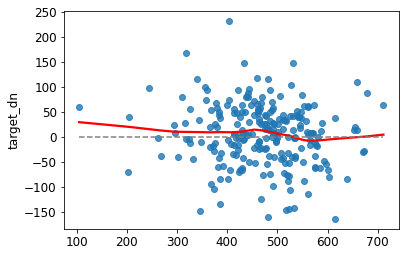

In [217]:
# 모형의 선형성 확인
sns.regplot(y_predict, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([y_predict.min(), y_predict.max()], [0, 0], '--', color='grey')

In [218]:
# 잔차의 정규성 확인 ( 샤피로 검정 ) -> 잔차는 정규분포를 따른다고 가정
import scipy.stats
sr = scipy.stats.zscore(residual)
scipy.stats.shapiro(residual) # p-value 값을 보아 유의수준 5%에서 잔차의 정규성이 위반되었다고 판단한다.

ShapiroResult(statistic=0.9896842837333679, pvalue=0.0952775701880455)

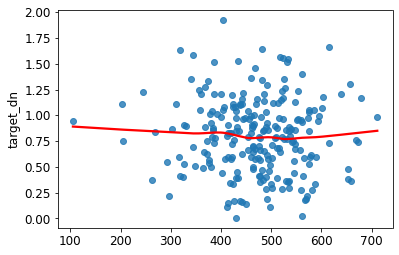

In [219]:
# 잔차의 등분산성 확인 -> 빨간 실선이 수평이면 이상적임
sns.regplot(y_predict, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})